This is the implementation of paper https://arxiv.org/pdf/1511.05952.pdf 

I have used the sample weight for updating the prioty. Please check if you want to modify that for your environment

# Priority Deep Q-Network (Double DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.6 GB  | Proc size: 153.9 MB
GPU RAM Free: 14304MB | Used: 775MB | Util   5% | Total 15079MB


In [2]:
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyvirtualdisplay
##!pip install piglet
!pip install pyglet==1.3.2  ###DONT CHANGE THE VERSION
!apt-get install xvfb
from pyvirtualdisplay import Display
!apt-get install cmake
!pip install setuptool
!pip install ez_setup
!pip install gym[atari] 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt aut

In [3]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


!pip -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


Usage:   
  pip3 <command> [options]

no such option: -m


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Define Environment

In [7]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [0]:
##Network

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed):
    '''
    Initialize Parameters
    '''
    super(QNetwork, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.seed = torch.manual_seed(seed)
    
    self.features = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

  
  def forward(self, state):
    """
    Build a network that maps state -> action values.
    """
    x = self.features(state)

    return x

In [0]:
import numpy as np
import random
from collections import namedtuple, deque
import math ## this is required 
import torch.optim as optim

##HYPERPARAMETERS

BUFFER_SIZE = int(1e5)  ##replay buffer size
BATCH_SIZE  = 128       ##minibatch size
GAMMA  = .99            ##discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
#LR = 1e-5  

UPDATE_EVERY = 4        ## how often local network gets copied to target network

if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

  


In [0]:
## Define the Replay Buffer ( Deque)

class ReplayBuffer:
  """
  Fixed-size buffer to store experience tuples.
  """
  def __init__(self,action_size, buffer_size, batch_size, seed, prob_alpha = 0.6):
    self.seed = random.seed(seed)
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.action_size = action_size
    self.prob_alpha = prob_alpha
    self.priority = np.zeros((self.buffer_size,) ,dtype= np.float32)

    
    ##self.experience = namedtuple("Experience", field_names =["state", "actions","rewards","next_state", "done"])
    ##self.memory = deque(maxlen= buffer_size)
    self.internalmemory = []
    self.pos = 0
    
  def add(self, state, action,rewards, next_state, done):
      
    ##experience = self.experience(state, action,rewards,next_state, done)
    ##self.memory.append(experience)
    
    if len(self.internalmemory)>0:
      
      max_prior = self.priority.max()
    else:
      max_prior = 1.0
    
    ##Replace or add memory depening of the current memory size
    if len(self.internalmemory)== self.buffer_size:
      self.internalmemory[self.pos] = (state, action,rewards, next_state, done)
    else:
      self.internalmemory.append((state, action,rewards, next_state, done))
    
    #print(self.pos,'!', len(self.internalmemory))
    

      
    ##print(max_prior)
    
    
    self.priority[self.pos] = max_prior
    #print(self.priority[self.pos])
    self.pos = (self.pos + 1) % self.buffer_size
      
  def sample(self,beta=0.4):
    '''
    Randomly sample a batch from experience
    '''
    
    ##print('xyz',len(self.internalmemory), self.priority[self.pos-1])
    
    
    
    ##experiences = random.sample(self.memory,k = self.batch_size)
    if len(self.internalmemory) == self.buffer_size:
      probs = self.priority
    else:
      probs = self.priority[:len(self.internalmemory)]
      
    probs = probs **self.prob_alpha
      
    probs = probs/sum(probs)
    
    ##print(probs)
      
    indices = np.random.choice(len(self.internalmemory), self.batch_size, p = probs)
    
    samples = [self.internalmemory[i] for i in indices]
    
    
      
    state = torch.from_numpy(np.vstack(  [e[0] for e in samples])).float().to(device)
    actions = torch.from_numpy(np.vstack([e[1] for e in samples])).long().to(device)  ## dont change to float
    rewards = torch.from_numpy(np.vstack([e[2] for e in samples])).float().to(device)
    next_state = torch.from_numpy(np.vstack([e[3] for e in samples])).float().to(device)
    done = torch.from_numpy(np.vstack([e[4] for e in samples])).float().to(device)
    
    #print(state.shape)
    
    weights = (len(self.internalmemory)*probs[indices])**(-beta)
    
    weights = weights/weights.max()
    
    #print('weights',weights.shape)
    
    return state,actions, rewards, next_state, done, indices, weights
  
  def __len__(self):
    """
    Return the current size of internal memory.
    """
    return len(self.internalmemory)
  
  def update_priority(self,batch_indices,priorities):
    
    #print(batch_indices.shape)
    #print(priorities.shape)
    for batch_index, priority in zip(batch_indices,priorities):
      self.priority[batch_index] = priority



In [0]:
## Define the Agent

class Agent():
  '''
  Interacts with and learns from the environment.
  '''
  def __init__(self,state_size,action_size, seed,batch_size= BATCH_SIZE,buffer_size= BUFFER_SIZE,lr=LR , gamma= GAMMA ):
    
    self.state_size = state_size
    self.action_size = action_size
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    self.lr = lr
    self.gamma = gamma
    
    self.seed = random.seed(seed)
    
    # Q-Network
    self.qnetwork_local =  QNetwork(self.state_size, self.action_size, seed).to(device)
    self.qnetwork_target = QNetwork(self.state_size , self.action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr= self.lr)
    self.criterion = nn.MSELoss()
    
    # Replay memory
    self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
    ##print('**', self.memory.priority)
    # Initialize time step (for updating every UPDATE_EVERY steps)
    self.t_step = 0
  
  
  def step(self,state,actions,rewards, next_state,done,beta):
    self.memory.add(state,actions,rewards, next_state,done)
    self.t_step =(self.t_step + 1)% UPDATE_EVERY
    ## dont learn whenever 1 batch is added.
    ##Rather wait for UPDATE_EVERY batch to be added before we call learn once
    if self.t_step==0:
      if len(self.memory)> self.batch_size:

        state,actions, rewards, next_state, done, indices, weights = self.memory.sample(beta)
        #print('**', weights.shape)
        self.learn(state,actions, rewards, next_state, done, indices, weights, self.gamma)
    
  def learn(self,state,actions, rewards, next_state, done, indices, weights, gamma):
    """
    Update value parameters using given batch of experience tuples.
    """
    ##state, actions, rewards,next_state, done = experiences 
    target_q = self.qnetwork_target(next_state).detach()
    target_values = rewards + gamma*torch.max(target_q, 1)[0].unsqueeze(1)*(1-done)
    current_values= self.qnetwork_local(state).gather(1, actions)    
    
    
    #print('$', ((current_values - target_values).pow(2)).shape)
    #print('$',weights.shape)
    # Compute loss
    ##loss = self.criterion(current_values,target_values)\
    weights = torch.tensor(weights.reshape(-1,1)).float().to(device)
    loss = (current_values - target_values).pow(2) * weights
    loss = loss + 1e-5 ## this is to avoid zero probability to pick a tuple
    #print('!!', indices.shape, loss.shape)
    self.memory.update_priority(indices,loss)
    
    loss= loss.mean()
    
    
    ##optimization step
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    
    # ----- Update the target network -----
    if self.t_step==0:
      ## when it comes here self.t_step will always be 0 anyways. 
      ## So you may remove this if condition
      self.soft_update(self.qnetwork_local, self.qnetwork_target,TAU)
    
  def soft_update(self, qnetwork_local, qnetwork_target,tau):
    '''
    Update the target Q Network
    '''
    for local_parms, target_parms in zip(qnetwork_local.parameters(), qnetwork_target.parameters()):
      target_parms.data.copy_(tau*local_parms.data + (1.0 -tau)*target_parms.data)
        
        
  def act(self, state, epsilon =0.0):

    """
    Returns actions for given state as per current policy.
    """
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)

    self.qnetwork_local.eval()
    with torch.no_grad():
      actions_values = self.qnetwork_local(state)

    ##Back to train mode
    self.qnetwork_local.train()

    # Epsilon-greedy action selection

    if random.random() > epsilon:
      return np.argmax(actions_values.cpu().data.numpy())
    else:
      return np.random.choice(np.arange(self.action_size))
      
    

In [0]:
def dqn(n_episodes = 2000, max_t = 1000, eps_start = 1.0, eps_end = .01, eps_decay = 0.995, trained_score=200.0):
  scores =[]
  scores_window = deque(maxlen = 100)
  eps = eps_start
  beta_start = 0.4
  beta_frames= 1000 ## set beta to 1 when episode no = beta_frames
  
  
  for episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    beta = min(1.0, beta_start +  episode*(1.0 -beta_start)/beta_frames)
    for t in range(max_t):
      action = agent.act(state,eps)
      next_state , rewards, done, _ = env.step(action)
      agent.step(state, action,rewards,next_state ,  done ,beta)
      state = next_state
      score += rewards
      if done:
        break
    scores_window.append(score)
    scores.append(score)
    eps = max(eps_end, eps*eps_decay)  ## reduce randomness epsilon as we learn
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
    if episode % 100 == 0:
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    ##if np.mean(scores_window)>=200.0:
    if np.mean(scores_window)>=trained_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        break
  return scores
    
  


Episode 100	Average Score: -177.03
Episode 200	Average Score: -152.09
Episode 300	Average Score: -144.79
Episode 400	Average Score: -79.89
Episode 500	Average Score: 5.72
Episode 600	Average Score: 150.75
Episode 649	Average Score: 200.56
Environment solved in 549 episodes!	Average Score: 200.56


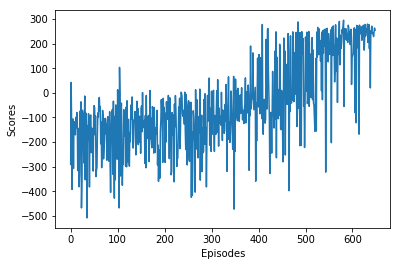

In [170]:
env_observation_space = 8
env_action_space = 4

agent = Agent(env_observation_space ,env_action_space, seed=0 )
scores = dqn()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)) , scores)

plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.show()

In [0]:
##For environment where CNN is required as part of QNetwork

In [0]:
class QNetwork(nn.Module):
  """Actor (Policy) Model."""
  def __init__(self, state_size, action_size, seed):
    '''
    Initialize Parameters
    '''
    super(QNetwork, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.seed = torch.manual_seed(seed)
    
    self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
    ##check this 3136 size when you are implementing.
    self.advantage = nn.Sequential(nn.Linear(3136,512),
                                   nn.ReLU(),
                                   nn.Linear(512,action_size)
                                  )
                                   
    self.value =     nn.Sequential(nn.Linear(3136,512),
                                   nn.ReLU(),
                                   nn.Linear(512,1)
                                  )
                                   

  
  def forward(self, state):
    """
    Build a network that maps state -> action values.
    """
    x = self.features(state)
    x= x.reshape(x.shape[0],-1)
    #advantage
    advantage = self.advantage(x)
    #value
    value = self.value(x)
    return value + advantage - advantage.mean()

In [0]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            


In [0]:
env.close()